In [6]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import to_date

In [8]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ChicagoCrimeWeatherAnalysis") \
    .getOrCreate()


In [10]:
#we_df = spark.read.csv('/content/drive/MyDrive/ChicagoWeatherDataset.csv', header=True, inferSchema=True)
#c_df = spark.read.csv('/content/drive/MyDrive/ChicagoCrimeDataset.csv', header=True, inferSchema=True)
we_df = spark.read.csv('Desktop/ChicagoWeatherDataset.csv', header=True, inferSchema=True)
c_df = spark.read.csv('Desktop/ChicagoCrimeDataset.csv', header=True, inferSchema=True)

In [11]:
c_df.show(2)

+--------+-----------+-------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+---------------+-----------+------------+--------------------+--------------------------+---------+---------------+-------------+-----+----------------------+----------------+------------+-----------+
|      ID|Case Number|         Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|     Updated On|   Latitude|   Longitude|            Location|Historical Wards 2003-2015|Zip Codes|Community Areas|Census Tracts|Wards|Boundaries - ZIP Codes|Police Districts|Police Beats|Wards 2023-|
+--------+-----------+-------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------

In [12]:
we_df.show(2)

+--------+----------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+-------------------+-------------------+---------+--------------------+--------------------+----+--------------------+
|    name|  datetime|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|preciptype|snow|snowdepth|windgust|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|severerisk|            sunrise|             sunset|moonphase|          conditions|         description|icon|            stations|
+--------+----------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-

In [13]:
# Convert date columns to proper date format
from pyspark.sql.functions import hour, minute, dayofmonth, month, year

weather_df = we_df.withColumn("date", to_date("datetime")).drop("datetime","name","severerisk", "sunrise","sunset","conditions","description","preciptype","stations","windgust")
crime_df = c_df.withColumn("date", to_date("Date", "M/d/yyyy H:mm")) \
               .withColumn("Arrest", col("Arrest").cast("string")) \
               .withColumn("hour", hour("date")) \
               .withColumn("minute", minute("date")) \
               .withColumn("day", dayofmonth("date")) \
               .withColumn("month", month("date")) \
               .select("Date", "ID","Block", "Case Number", "Primary Type", "Arrest", "Year", "hour", "minute", "day", "month","District","Ward","Community Area")


In [14]:
weather_df.show(2)

+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+---------+----+----------+
|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|snow|snowdepth|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|moonphase|icon|      date|
+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+---------+----+----------+
|   82.1|   67.6|76.6|        84.0|        67.6|     77.2|62.3|    61.5| 0.204|       100|      29.17| 0.0|      0.0|     16.8|  220.9|          1014.5|      85.9|       9.7|          69.3|        5.9|      3|     0.94|rain|2021-08-06|
|   88.3|   67.4|78.4|        91.4|        67.4|     80.

In [15]:
from pyspark.sql.functions import month, when

# Add a new column "climate" based on the month of the date
weather_df = weather_df.withColumn("month2", month("date"))
weather_df = weather_df.withColumn("climate",
                               when((weather_df["month2"] >= 6) & (weather_df["month2"] <= 9), "summer")
                               .when((weather_df["month2"] >= 10) & (weather_df["month2"] <= 11), "autumn")
                               .when((weather_df["month2"] >= 12) | (weather_df["month2"] <= 2), "winter")
                               .otherwise("spring"))
weather_df.show(2)

+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+---------+----+----------+------+-------+
|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|snow|snowdepth|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|moonphase|icon|      date|month2|climate|
+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+---------+----+----------+------+-------+
|   82.1|   67.6|76.6|        84.0|        67.6|     77.2|62.3|    61.5| 0.204|       100|      29.17| 0.0|      0.0|     16.8|  220.9|          1014.5|      85.9|       9.7|          69.3|        5.9|      3|     0.94|rain|2021-08-06|     8| summ

In [16]:
crime_df.show(2)

+----------+--------+--------------------+-----------+------------------+------+----+----+------+---+-----+--------+----+--------------+
|      Date|      ID|               Block|Case Number|      Primary Type|Arrest|Year|hour|minute|day|month|District|Ward|Community Area|
+----------+--------+--------------------+-----------+------------------+------+----+----+------+---+-----+--------+----+--------------+
|2021-08-06|12445731|070XX S PRINCETON...|   JE328821|           ASSAULT| false|2021|   0|     0|  6|    8|       7|   6|            69|
|2021-08-06|12449835|  081XX S VERNON AVE|   JE333616|DECEPTIVE PRACTICE| false|2021|   0|     0|  6|    8|       6|   6|            44|
+----------+--------+--------------------+-----------+------------------+------+----+----+------+---+-----+--------+----+--------------+
only showing top 2 rows



In [17]:
# dropping the rows with null values which are like 70 rows
crime_df = crime_df.na.drop()


In [18]:
from pyspark.sql.functions import col, sum as spark_sum

# Count the number of null values in each column
null_counts = crime_df.select([spark_sum(col(column).isNull().cast('int')).alias(column) for column in crime_df.columns])
null_counts.show()

+----+---+-----+-----------+------------+------+----+----+------+---+-----+--------+----+--------------+
|Date| ID|Block|Case Number|Primary Type|Arrest|Year|hour|minute|day|month|District|Ward|Community Area|
+----+---+-----+-----------+------------+------+----+----+------+---+-----+--------+----+--------------+
|   0|  0|    0|          0|           0|     0|   0|   0|     0|  0|    0|       0|   0|             0|
+----+---+-----+-----------+------------+------+----+----+------+---+-----+--------+----+--------------+



In [19]:
weather_df.show(2)

+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+---------+----+----------+------+-------+
|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|snow|snowdepth|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|moonphase|icon|      date|month2|climate|
+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+---------+----+----------+------+-------+
|   82.1|   67.6|76.6|        84.0|        67.6|     77.2|62.3|    61.5| 0.204|       100|      29.17| 0.0|      0.0|     16.8|  220.9|          1014.5|      85.9|       9.7|          69.3|        5.9|      3|     0.94|rain|2021-08-06|     8| summ

In [20]:
#Joining the weahter df and crime df with date
joined_df = crime_df.join(weather_df, ["date"])

In [21]:
# counting the unique values of ward becuse we are doing the hotspot prediction based oin the ward.
distinct_count = joined_df.select("Ward").distinct().count()
print(distinct_count)


50


In [22]:
joined_df.show(2)

+----------+--------+--------------------+-----------+------------------+------+----+----+------+---+-----+--------+----+--------------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+---------+----+------+-------+
|      Date|      ID|               Block|Case Number|      Primary Type|Arrest|Year|hour|minute|day|month|District|Ward|Community Area|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|snow|snowdepth|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|moonphase|icon|month2|climate|
+----------+--------+--------------------+-----------+------------------+------+----+----+------+---+-----+--------+----+--------------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+--------

In [23]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Exploratory Data Analysis

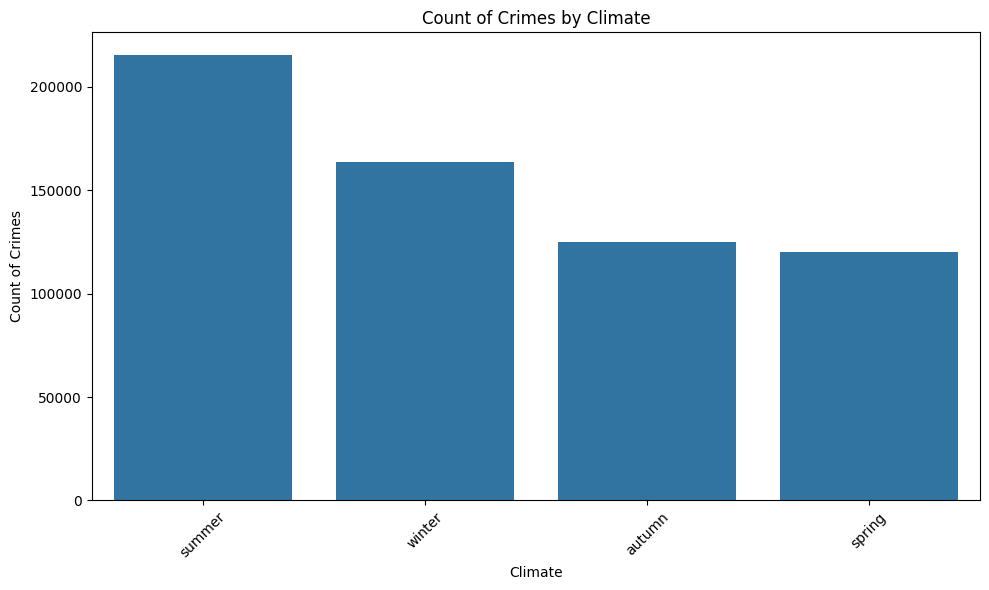

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

climate_counts = joined_df.groupBy("climate").count().orderBy("count", ascending=False)

# Convert the result to Pandas DataFrame for plotting
climate_counts_pd = climate_counts.toPandas()

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x="climate", y="count", data=climate_counts_pd)
plt.title("Count of Crimes by Climate")
plt.xlabel("Climate")
plt.ylabel("Count of Crimes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# the follwoing plot shows the number of the crimes happedn during those seasons in the three years of data we took.

In [ ]:
edadf = joined_df.toPandas()

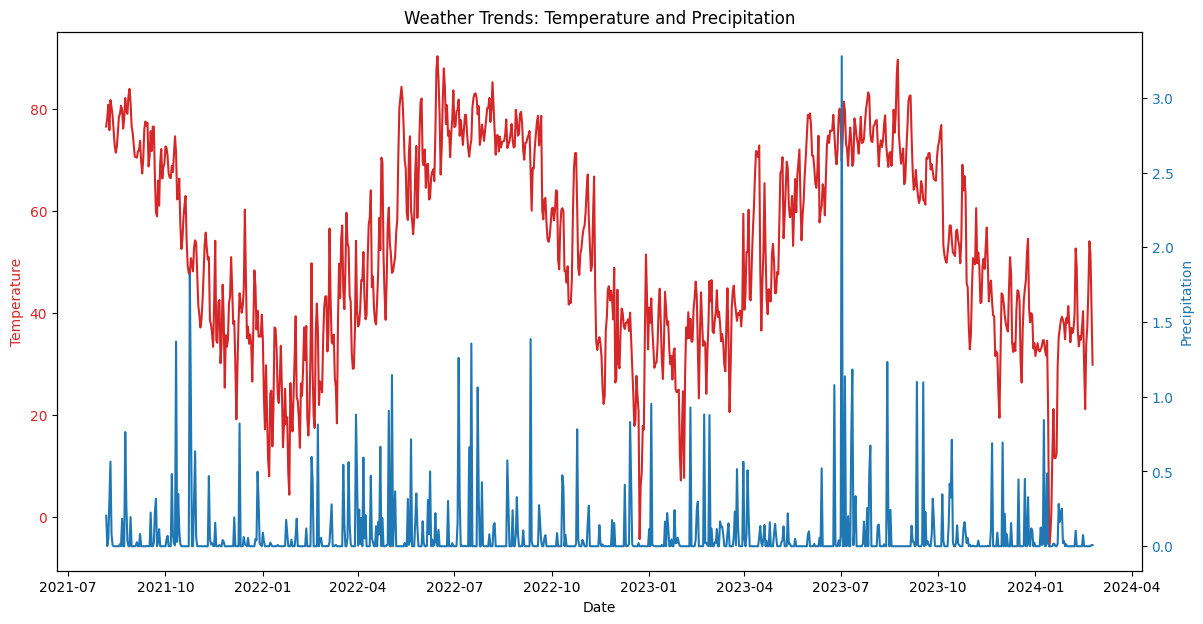

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Temperature trend
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature', color='tab:red')
ax1.plot(edadf['Date'], edadf['temp'], color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a twin axis to plot precipitation
ax2 = ax1.twinx()
ax2.set_ylabel('Precipitation', color='tab:blue')
ax2.plot(edadf['Date'], edadf['precip'], color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Weather Trends: Temperature and Precipitation')
plt.show()

# Crime count - Regression

For the crime count prediction we have to assume we dont have any crime data except the date, so we are grouping the crime df with the date and time counting the distinct ID to get the number of crimes happend in the chicago during that day.

In [ ]:
from pyspark.sql.functions import countDistinct

# Group by 'Date' and 'Primary Type', then count the occurrences
result_df = joined_df.groupBy("Date","Year","hour","minute","day","month")\
                     .agg(countDistinct("ID").alias("CrimeCount"))
result_df.show(2)


+----------+----+----+------+---+-----+----------+
|      Date|Year|hour|minute|day|month|CrimeCount|
+----------+----+----+------+---+-----+----------+
|2021-08-29|2021|   0|     0| 29|    8|       650|
|2021-11-21|2021|   0|     0| 21|   11|       585|
+----------+----+----+------+---+-----+----------+
only showing top 2 rows



In [ ]:
# joining the weather df and the calculate crime count df with the date column
joined_df2 = result_df.join(weather_df, ["date"], "inner")


In [ ]:
joined_df2.show(2)

+----------+----+----+------+---+-----+----------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+---------+----+------+-------+
|      Date|Year|hour|minute|day|month|CrimeCount|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|snow|snowdepth|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|moonphase|icon|month2|climate|
+----------+----+----+------+---+-----+----------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+---------+----+------+-------+
|2021-08-29|2021|   0|     0| 29|    8|       650|   89.0|   77.1|81.3|        95.3|        77.1|     83.7|70.1|    69.2| 0.195|     

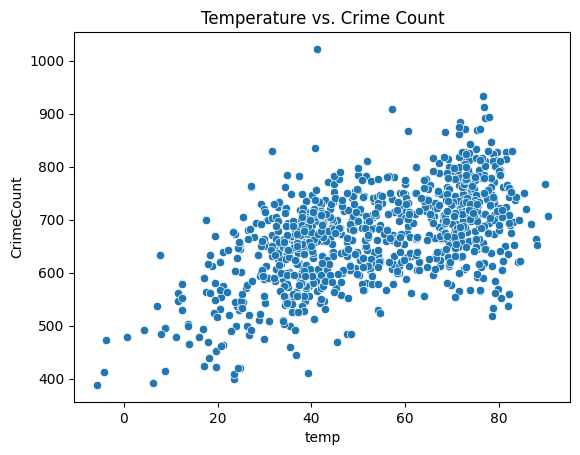

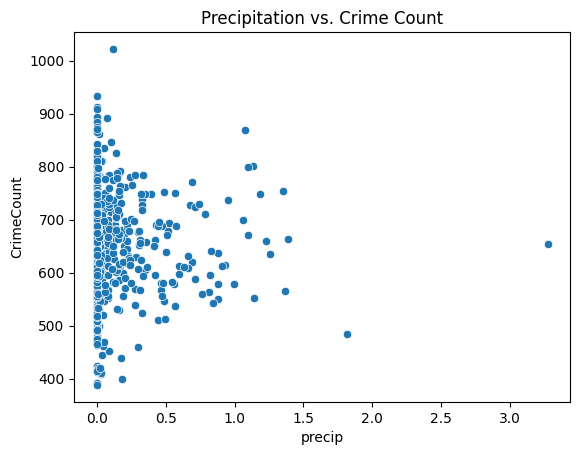

In [ ]:
import seaborn as sns

edaf2 = joined_df2.toPandas()
# Scatter plot of temperature and crime count
sns.scatterplot(x='temp', y='CrimeCount', data=edaf2)
plt.title('Temperature vs. Crime Count')
plt.show()

# Scatter plot of precipitation and crime count
sns.scatterplot(x='precip', y='CrimeCount', data=edaf2)
plt.title('Precipitation vs. Crime Count')
plt.show()

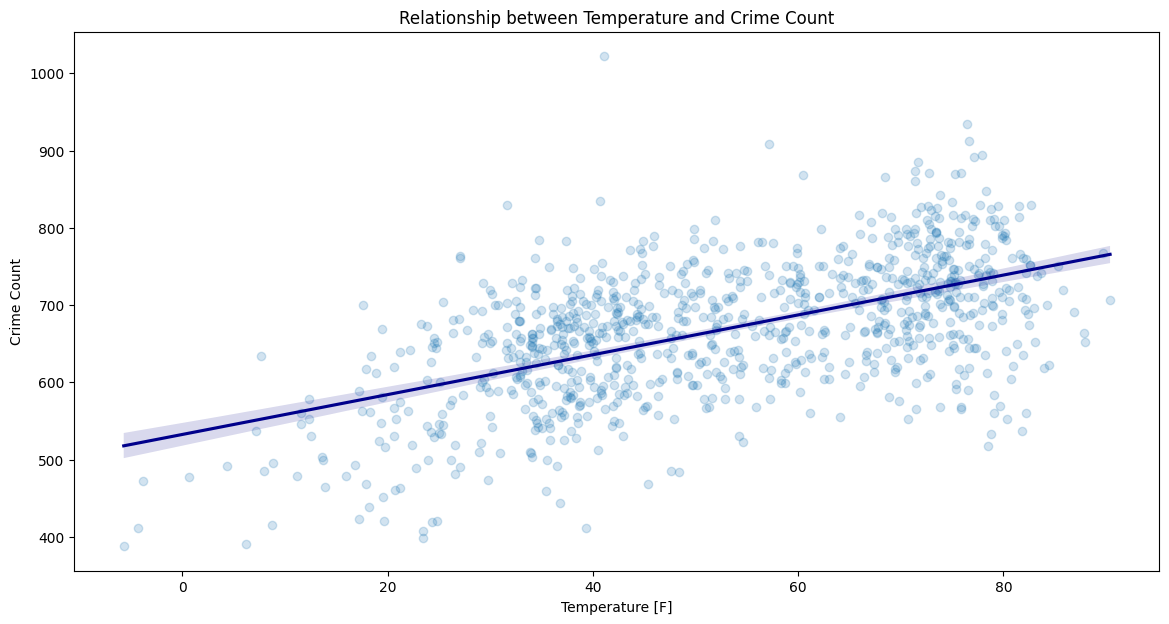

In [ ]:
# Creating a scatter plot with a regression line

plt.figure(figsize=(14, 7))
sns.regplot(x='temp', y='CrimeCount', data=edaf2, scatter_kws={'alpha':0.2}, line_kws={'color':'darkblue'})

plt.title('Relationship between Temperature and Crime Count')
plt.xlabel('Temperature [F]')
plt.ylabel('Crime Count')
plt.show()

Linear Regression model

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


# Prepare features and target variable
assembler = VectorAssembler(inputCols=[ 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
                   'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windspeed', 'winddir',
                   'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
                   'moonphase','Year','hour','minute','day','month'], outputCol='features')
daily_data_assembled = assembler.transform(joined_df2)

daily_data_final = daily_data_assembled.select('features', 'CrimeCount')

# Split data into training and testing sets
(train_data, test_data) = daily_data_final.randomSplit([0.8, 0.2], seed=42)

# Initialize and train the linear regression model
lr = LinearRegression(featuresCol='features', labelCol='CrimeCount')
model = lr.fit(train_data)

# Predict on test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol='CrimeCount', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
evaluator = RegressionEvaluator(labelCol='CrimeCount', predictionCol='prediction', metricName='r2')
r2 = evaluator.evaluate(predictions)

print(f'RMSE: {rmse}')
print(f'R^2: {r2}')


RMSE: 56.15443270747258
R^2: 0.6515654789301462


RandomForest Regressor model.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Assemble features
feature_columns1 = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
                   'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windspeed', 'winddir',
                   'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
                   'moonphase','Year','hour','minute','day','month']
assembler = VectorAssembler(inputCols=feature_columns1, outputCol='features')

# Random Forest regressor
rf = RandomForestRegressor(featuresCol='features', labelCol='CrimeCount')

# Pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Split the data into training and test sets
(training_data, test_data) = joined_df2.randomSplit([0.8, 0.2], seed=7)

# Train the model
model = pipeline.fit(training_data)

# Make predictions
predictions2 = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol='CrimeCount', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")

# Show some example predictions
predictions.select('CrimeCount', 'prediction').show()


RMSE: 51.2022528080547
+----------+-----------------+
|CrimeCount|       prediction|
+----------+-----------------+
|       552|612.6859021622962|
|       565|675.6604431934169|
|       599|673.5354543348465|
|       607|667.7622111994194|
|       604|669.2063223082821|
|       610|670.3647854536447|
|       560|615.4690386849513|
|       674|653.8005153468721|
|       650|626.8620825831825|
|       618|668.5025195147712|
|       668|649.1906292095442|
|       658|674.1231336119529|
|       656| 651.454686070311|
|       628|634.5941883446054|
|       595|646.0491340686588|
|       649|654.4461703451113|
|       605|634.9920197138159|
|       607|646.6468475900203|
|       631|635.3098320434686|
|       620|638.6743360646672|
+----------+-----------------+
only showing top 20 rows



In the above the linear regresion model and Random forest regression model the RMSE is around 50 which is higher than what we excpeted but we belive that the climate and time plays a very small roll in prediciting the crimes and there many other factors should be considered to get the best results. To get the best model we used the crossvalidator in the followind code.

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# the hyperparameters grid
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# the cross-validator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)

# Train the model using the cross-validator
cv_model = crossval.fit(training_data)

# Make predictions with the best model
best_model = cv_model.bestModel
predictions = best_model.transform(test_data)

# Evaluate the best model
rmse = evaluator.evaluate(predictions)
print(f"Best model RMSE: {rmse}")

# Show some example predictions
predictions.select('CrimeCount', 'prediction').show()


# Hotspots

For the hotspots prediction with the whether data we are consider wards as the spots.So we are grouping the crime df with the date , time and ward with the distinct count of ID which gives crime count.To predict the hotspot we followed two methods:

Method -1 : In this we assume we only have the date,time, wards and whether data. first thing to predict the hotspots we need the number of crimes in that ward which we used A random forest regression model to get that then once we have the crime counts then used the classification model to label the ward whether it is hotspot or not. (Or else without any classfication model we created a function which will compare every wards avg crime count with from that date past 30 days chicagos avg crime count and label it with 1 if it is greater or else 0.)


Method -2 in this we assume we know that crime counts and so just need a classification model to predict the ward is hotspot or not.(or else we can use same funciton before to label the ward)


method - 1

In [ ]:
from pyspark.sql.functions import countDistinct, avg

# Calculate count distinct of 'ID' for each ward with in that date and time
df_counts1 = crime_df.groupBy("Date", "Year", "hour", "minute", "day", "month", "Ward")\
                     .agg(countDistinct("ID").alias("avg_Crime_count")).orderBy("Date")

# Group by 'Date', 'Year', 'hour', 'minute', 'day', 'month', 'Block' and calculate the average of 'ID_count'
#df_hotspots1 = df_counts1.groupBy("Date", "Year", "hour", "minute", "day", "month", "Ward")\
 #                     .agg(avg("ID_count").alias("avg_Crime_Count"))
df_counts1.show(2)

+----------+----+----+------+---+-----+----+---------------+
|      Date|Year|hour|minute|day|month|Ward|avg_Crime_count|
+----------+----+----+------+---+-----+----+---------------+
|2021-08-06|2021|   0|     0|  6|    8|  12|              7|
|2021-08-06|2021|   0|     0|  6|    8|  30|              6|
+----------+----+----+------+---+-----+----+---------------+
only showing top 2 rows



In [ ]:
# create a tempview to use the spraksql
df_counts1.createOrReplaceTempView("avg_count30")


In [ ]:
# this following code will calculate the daily averages and the past 30 chicagos crime data
query = """
WITH avg1 AS (
    SELECT Date, AVG(avg_Crime_count) AS that_day_avg
    FROM avg_count30
    GROUP BY Date
)
SELECT Date, that_day_avg,
       AVG(that_day_avg) OVER (ORDER BY Date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS 30_days_avg_Crime_Count
FROM avg1
ORDER BY Date

"""

df8 = spark.sql(query)
df8.show(3)


+----------+------------------+-----------------------+
|      Date|      that_day_avg|30_days_avg_Crime_Count|
+----------+------------------+-----------------------+
|2021-08-06|12.040816326530612|     12.040816326530612|
|2021-08-07|12.489795918367347|      12.26530612244898|
|2021-08-08|             12.42|     12.316870748299321|
+----------+------------------+-----------------------+
only showing top 3 rows



In [ ]:
# the two wards data and chicagos avg data with date
df_hotspots1 = df_counts1.join(df8, ["date"], "inner")
df_hotspots1.show(2)

+----------+----+----+------+---+-----+----+---------------+------------------+-----------------------+
|      Date|Year|hour|minute|day|month|Ward|avg_Crime_count|      that_day_avg|30_days_avg_Crime_Count|
+----------+----+----+------+---+-----+----+---------------+------------------+-----------------------+
|2021-08-06|2021|   0|     0|  6|    8|  41|              8|12.040816326530612|     12.040816326530612|
|2021-08-06|2021|   0|     0|  6|    8|  44|             12|12.040816326530612|     12.040816326530612|
+----------+----+----+------+---+-----+----+---------------+------------------+-----------------------+
only showing top 2 rows



In [ ]:
#joining with wheather
joined_df3a = df_hotspots1.join(weather_df, ["date"], "inner")
joined_df3a.show(2)

+----------+----+----+------+---+-----+----+---------------+------------------+-----------------------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+---------+----+------+-------+
|      Date|Year|hour|minute|day|month|Ward|avg_Crime_count|      that_day_avg|30_days_avg_Crime_Count|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|snow|snowdepth|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|moonphase|icon|month2|climate|
+----------+----+----+------+---+-----+----+---------------+------------------+-----------------------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+-----

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Convert categorical variables to numerical format
stringIndexer = StringIndexer(inputCol="climate", outputCol="climate_index")
encoder = OneHotEncoder(inputCol="climate_index", outputCol="climate_encoded")

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=["Year", "hour", "minute", "day", "month", 'tempmax', 'tempmin', 'temp',
                                       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
                                       'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windspeed', 'winddir',
                                       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
                                       'moonphase', "climate_encoded","Ward"],
                             outputCol="features")

# Split the data into training and testing sets
(training_data, test_data) = joined_df3a.randomSplit([0.8, 0.2], seed=7)

# Train a Random Forest model
rf1a = RandomForestRegressor(featuresCol="features", labelCol="avg_Crime_count")
pipeline = Pipeline(stages=[stringIndexer, encoder, assembler, rf1a])
model = pipeline.fit(training_data)

# Make predictions
predictions_rf1a = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="avg_Crime_count", metricName="rmse")
rmse = evaluator.evaluate(predictions_rf1a)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 6.975860389113872


In [ ]:
# Show some example predictions
predictions_rf1a.select('avg_Crime_count', 'prediction').show()

+---------------+------------------+
|avg_Crime_count|        prediction|
+---------------+------------------+
|             26| 14.38031587287845|
|             13| 14.38031587287845|
|             11|13.422154735668997|
|              6|13.422154735668997|
|              7|13.422154735668997|
|             23| 13.97268349121281|
|             14| 13.97268349121281|
|             10| 13.97268349121281|
|             29| 13.97268349121281|
|             10| 13.97268349121281|
|              6|  9.88171074399052|
|              5|10.557336459155536|
|              6|10.557336459155536|
|              6|10.557336459155536|
|              9|14.187589796248925|
|             15|14.128878941578572|
|             12|14.128878941578572|
|             19|14.128878941578572|
|              8|14.128878941578572|
|             27|14.128878941578572|
+---------------+------------------+
only showing top 20 rows



The regression model gave a RMSE of 6.5 which is a best result that we have till now. after this etiher a classification model or the function we wrote will determine the a ward hotspot or not.

In [ ]:
predictions_rf1a.show(2)

+----------+----+----+------+---+-----+----+---------------+------------------+-----------------------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+---------+----+------+-------+-------------+---------------+--------------------+-----------------+
|      Date|Year|hour|minute|day|month|Ward|avg_Crime_count|      that_day_avg|30_days_avg_Crime_Count|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|snow|snowdepth|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|moonphase|icon|month2|climate|climate_index|climate_encoded|            features|       prediction|
+----------+----+----+------+---+-----+----+---------------+------------------+-----------------------+-------+-------+----+------------+------------+---------+----+--------+----

In [ ]:
# the follwong funciton will label the wards whether thet are hotspot or not by comparing the avg.
def calculate_hotspot_labell(df_hotspots, column):
    df_hotspots = df_hotspots.withColumnRenamed(column, "avg_crimecount_pred")
    df_hotspots.createOrReplaceTempView("avg_count302")
    query = """
      WITH avg12 AS (
          SELECT Date, AVG(avg_crimecount_pred) AS that_day_avg2
          FROM avg_count302
          GROUP BY Date
      )
      SELECT Date, that_day_avg2,
            AVG(that_day_avg2) OVER (ORDER BY Date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS 30_days_avg_Crime_Count2
      FROM avg12
      ORDER BY Date

      """
    df8 = spark.sql(query)

    j_df = df_hotspots.join(df8, ["date"], "inner")

    join_dff = j_df.withColumn("hotspot_label", when(F.col("avg_crimecount_pred") > F.col("30_days_avg_Crime_Count2"), 1).otherwise(0))

    return join_dff

In [ ]:
# Call the function to calculate hotspot labels
result_df = calculate_hotspot_labell(predictions_rf1a, 'prediction')
# Show the result
result_df.show(2)

+----------+----+----+------+---+-----+----+---------------+------------------+-----------------------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+---------+----+------+-------+-------------+---------------+--------------------+-------------------+------------------+------------------------+-------------+
|      Date|Year|hour|minute|day|month|Ward|avg_Crime_count|      that_day_avg|30_days_avg_Crime_Count|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|snow|snowdepth|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|moonphase|icon|month2|climate|climate_index|climate_encoded|            features|avg_crimecount_pred|     that_day_avg2|30_days_avg_Crime_Count2|hotspot_label|
+----------+----+----+------+---+-----+----+--------------

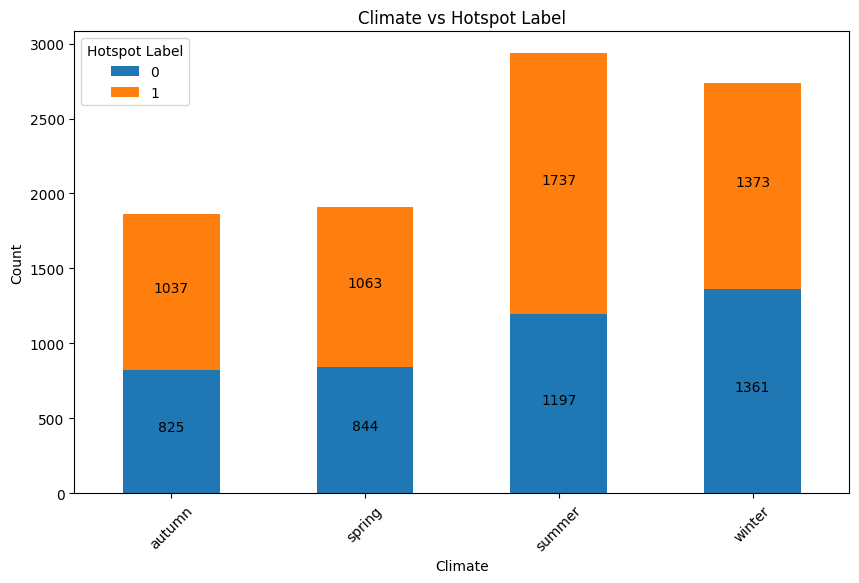

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = result_df.toPandas()

# Group by climate and hotspot_label, calculate counts
grouped = pandas_df.groupby(['climate', 'hotspot_label']).size().unstack(fill_value=0)

# Plotting
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Climate vs Hotspot Label')
plt.xlabel('Climate')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Hotspot Label')

# Annotate with hotspot label count values for the bars
for i, column in enumerate(grouped.columns):
    for j, value in enumerate(grouped[column]):
        ax.text(j, grouped.iloc[:, :i].sum(axis=1)[j] + value / 2, str(value), ha='center')

plt.show()

# the followiong plot shows the hotspor labels in the climate seasons. as assumed summer has the more hotspots than the others.

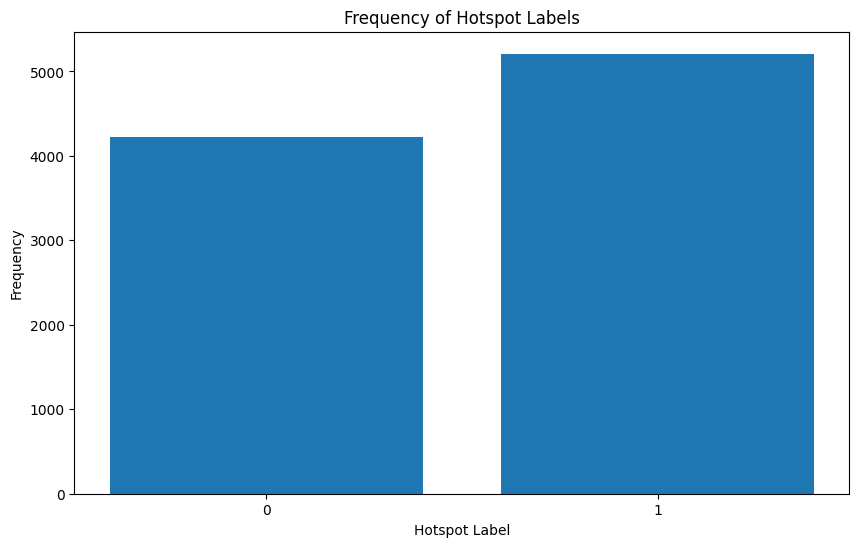

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Group the data by hotspot_label and count the frequency
frequency_df2 = result_df.groupBy("hotspot_label").count().orderBy("hotspot_label")

# Convert the result to a Pandas DataFrame
frequency_pd_df2 = frequency_df2.toPandas()

# Plot the frequency
plt.figure(figsize=(10, 6))
plt.bar(frequency_pd_df2["hotspot_label"], frequency_pd_df2["count"])
plt.xlabel("Hotspot Label")
plt.ylabel("Frequency")
plt.title("Frequency of Hotspot Labels")
plt.xticks([0, 1])
plt.show()


In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

# Convert categorical variables to numerical format
stringIndexer1a = StringIndexer(inputCol="climate", outputCol="climate_index2")
encoder1a = OneHotEncoder(inputCol="climate_index2", outputCol="climate_encoded2")


# Assemble features into a single vector
assembler1a = VectorAssembler(inputCols=["Year", "hour", "minute", "Ward","day", "month", 'tempmax', 'tempmin', 'temp',
                                       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
                                        'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windspeed', 'winddir',
                                         'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
                                          'moonphase',"climate_encoded2","avg_crimecount_pred","that_day_avg2"],
                             outputCol="features2")

# Split the data into training and testing sets
(training_data, test_data) = result_df.randomSplit([0.8, 0.2], seed=7)

# Train a Random Forest model
rf1a = RandomForestClassifier(featuresCol="features2", labelCol="hotspot_label")
pipeline1a = Pipeline(stages=[ stringIndexer1a, encoder1a, assembler1a, rf1a])
model = pipeline1a.fit(training_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="hotspot_label")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)


Accuracy: 0.998276701488789


method - 2

In [ ]:
from pyspark.sql.functions import countDistinct, avg

# Calculate count distinct of 'ID' for each group
df_counts = crime_df.groupBy("Date", "Year", "hour", "minute", "day", "month", "Ward")\
                     .agg(countDistinct("ID").alias("avg_Crime_Count"))

# Group by 'Date', 'Year', 'hour', 'minute', 'day', 'month', 'Block' and calculate the average of 'ID_count'
#df_hotspots = df_counts.groupBy("Date", "Year", "hour", "minute", "day", "month", "Ward")\
 #                     .agg(avg("ID_count").alias("avg_Crime_Count"))

# Show the result
df_counts.show(2)


+----------+----+----+------+---+-----+----+---------------+
|      Date|Year|hour|minute|day|month|Ward|avg_Crime_Count|
+----------+----+----+------+---+-----+----+---------------+
|2021-08-16|2021|   0|     0| 16|    8|  48|              6|
|2021-09-09|2021|   0|     0|  9|    9|   1|             20|
+----------+----+----+------+---+-----+----+---------------+
only showing top 2 rows



In [ ]:
# that same funciton as before
def calculate_hotspot_label(df_hotspots):
    df_hotspots.createOrReplaceTempView("avg_count30_")
    query = """
      WITH avg13 AS (
          SELECT Date, AVG(avg_Crime_Count) AS that_day_avg3
          FROM avg_count30_
          GROUP BY Date
      )
      SELECT Date, that_day_avg3,
            AVG(that_day_avg3) OVER (ORDER BY Date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS 30_days_avg_Crime_Count3
      FROM avg13
      ORDER BY Date

      """
    df8 = spark.sql(query)

    j_df = df_hotspots.join(df8, ["date"], "inner")

    join_dff = j_df.withColumn("hotspot_label", when(F.col("avg_Crime_Count") > F.col("30_days_avg_Crime_Count3"), 1).otherwise(0))

    return join_dff

In [ ]:
# Call the function to calculate hotspot labels
j_dff = calculate_hotspot_label(df_counts)

# Show the result
j_dff.show(2)

+----------+----+----+------+---+-----+----+---------------+------------------+------------------------+-------------+
|      Date|Year|hour|minute|day|month|Ward|avg_Crime_Count|     that_day_avg3|30_days_avg_Crime_Count3|hotspot_label|
+----------+----+----+------+---+-----+----+---------------+------------------+------------------------+-------------+
|2021-08-06|2021|   0|     0|  6|    8|  41|              8|12.040816326530612|      12.040816326530612|            0|
|2021-08-06|2021|   0|     0|  6|    8|  44|             12|12.040816326530612|      12.040816326530612|            0|
+----------+----+----+------+---+-----+----+---------------+------------------+------------------------+-------------+
only showing top 2 rows



In [ ]:
from pyspark.sql import functions as F

max_crime_count = j_dff.select(F.max('avg_Crime_Count')).collect()[0][0]
print("Max Crime Count:", max_crime_count)


Max Crime Count: 186


In [ ]:
joined_df3 = j_dff.join(weather_df, ["date"], "inner") # joining the weather df and resulted df

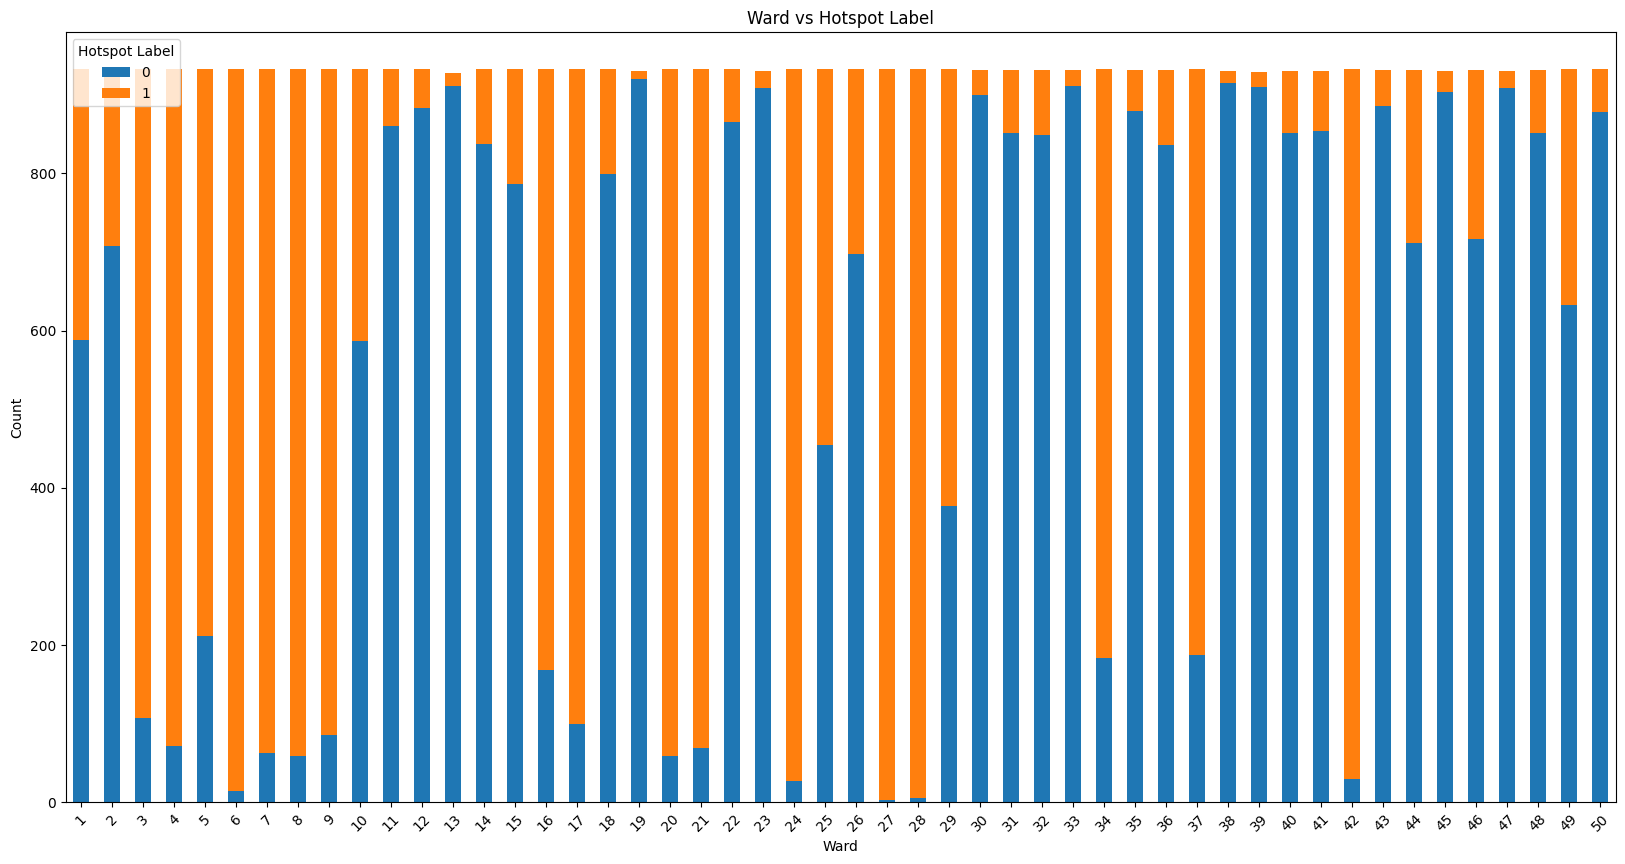

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = joined_df3.toPandas()

# Group by climate and hotspot_label, calculate counts
grouped = pandas_df.groupby(['Ward', 'hotspot_label']).size().unstack(fill_value=0)

# Plotting
ax = grouped.plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title('Ward vs Hotspot Label')
plt.xlabel('Ward')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Hotspot Label')
plt.show()

# the following plot shows how many times an ward is hotspot or not in the three years of the data we had.

In [ ]:
from pyspark.sql.functions import col, sum as spark_sum

# Count the number of null values in each column
null_counts = joined_df3.select([spark_sum(col(column).isNull().cast('int')).alias(column) for column in joined_df3.columns])

# Display the null counts
null_counts.show()

+----+----+----+------+---+-----+----+---------------+-------------+------------------------+-------------+-------+-------+----+------------+------------+---------+---+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+---------+----+------+-------+
|Date|Year|hour|minute|day|month|Ward|avg_Crime_Count|that_day_avg3|30_days_avg_Crime_Count3|hotspot_label|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike|dew|humidity|precip|precipprob|precipcover|snow|snowdepth|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|moonphase|icon|month2|climate|
+----+----+----+------+---+-----+----+---------------+-------------+------------------------+-------------+-------+-------+----+------------+------------+---------+---+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+----

In [ ]:
joined_df3.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Year: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- avg_Crime_Count: long (nullable = false)
 |-- that_day_avg3: double (nullable = true)
 |-- 30_days_avg_Crime_Count3: double (nullable = true)
 |-- hotspot_label: integer (nullable = false)
 |-- tempmax: double (nullable = true)
 |-- tempmin: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- feelslikemax: double (nullable = true)
 |-- feelslikemin: double (nullable = true)
 |-- feelslike: double (nullable = true)
 |-- dew: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- precip: double (nullable = true)
 |-- precipprob: integer (nullable = true)
 |-- precipcover: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- snowdepth: double (nullable = true)
 |-- windspeed: double (

In [ ]:
joined_df3.count()

46613

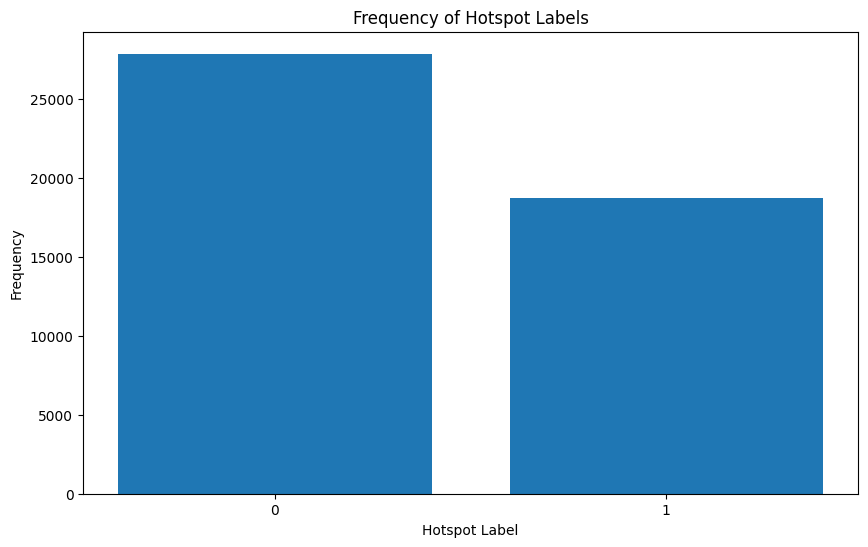

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Group the data by hotspot_label and count the frequency
frequency_df = joined_df3.groupBy("hotspot_label").count().orderBy("hotspot_label")

# Convert the result to a Pandas DataFrame
frequency_pd_df = frequency_df.toPandas()

# Plot the frequency
plt.figure(figsize=(10, 6))
plt.bar(frequency_pd_df["hotspot_label"], frequency_pd_df["count"])
plt.xlabel("Hotspot Label")
plt.ylabel("Frequency")
plt.title("Frequency of Hotspot Labels")
plt.xticks([0, 1])
plt.show()

# the following plot shows the frequency of the hotspot labels

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

# Convert categorical variables to numerical format
stringIndexer = StringIndexer(inputCol="climate", outputCol="climate_index")
encoder = OneHotEncoder(inputCol="climate_index", outputCol="climate_encoded")


# Assemble features into a single vector
assembler = VectorAssembler(inputCols=["Year", "hour", "minute", "Ward","day", "month", 'tempmax', 'tempmin', 'temp',
                                       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
                                        'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windspeed', 'winddir',
                                         'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
                                          'moonphase',"climate_encoded","avg_Crime_Count","that_day_avg3"],
                             outputCol="features")

# Split the data into training and testing sets
(training_data, test_data) = joined_df3.randomSplit([0.8, 0.2], seed=7)

# Train a Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="hotspot_label")
pipeline = Pipeline(stages=[ stringIndexer, encoder, assembler, rf])
model = pipeline.fit(training_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="hotspot_label")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)


Accuracy: 0.9901591696440516


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# Train a Decision Tree model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="hotspot_label")
pipeline_dt = Pipeline(stages=[stringIndexer, encoder, assembler, dt])
model_dt = pipeline_dt.fit(training_data)

# Make predictions with the Decision Tree model
predictions_dt = model_dt.transform(test_data)

# Evaluate the Decision Tree model
evaluator_dt = BinaryClassificationEvaluator(labelCol="hotspot_label")
accuracy_dt = evaluator_dt.evaluate(predictions_dt)
print("Decision Tree Accuracy:", accuracy_dt)


Decision Tree Accuracy: 0.9946226743419114


# Crime Type Prediction


In [24]:
ctdf=joined_df
ctdf.show(2)

+----------+--------+--------------------+-----------+------------------+------+----+----+------+---+-----+--------+----+--------------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+---------+---------+-------+----------------+----------+----------+--------------+-----------+-------+---------+----+------+-------+
|      Date|      ID|               Block|Case Number|      Primary Type|Arrest|Year|hour|minute|day|month|District|Ward|Community Area|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|snow|snowdepth|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|moonphase|icon|month2|climate|
+----------+--------+--------------------+-----------+------------------+------+----+----+------+---+-----+--------+----+--------------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----+--------

In [25]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer ,OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np
import matplotlib.pyplot as plt


# Prepare features and target variable
features = ["Year", "hour", "minute", "Ward","day", "month", 'tempmax', 'tempmin', 'temp',
                                       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
                                        'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windspeed', 'winddir',
                                         'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
                                          'moonphase']
assembler = VectorAssembler(inputCols=features, outputCol='features')
daily_data_assembled = assembler.transform(ctdf)

# Convert the target variable 'Primary Type' to numeric using StringIndexer
indexer = StringIndexer(inputCol='Primary Type', outputCol='label')
daily_data_indexed = indexer.fit(daily_data_assembled).transform(daily_data_assembled)

# Split the dataset into training and testing sets
(training_data, testing_data) = daily_data_indexed.randomSplit([0.8, 0.2], seed=7)

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(featuresCol='features', labelCol='label', seed=7)

# Fit the model on the training data
dt_model = dt_classifier.fit(training_data)

# Predict the crime types on the testing set
predictions = dt_model.transform(testing_data)

# Evaluate the accuracy of the model on the testing set
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy of Decision Tree classifier on test set: {accuracy:.2%}')

Accuracy of Decision Tree classifier on test set: 23.93%


For the crime types the classifciations models arent performing as we expected. we belive this low is accuracu is caused due to the lack of information like the predicting individual crime type the model need more information then the that day weather data.